   survived  pclass     sex   age  sibsp  parch     fare embarked  class  \
0         0       3    male  22.0      1      0   7.2500        S  Third   
1         1       1  female  38.0      1      0  71.2833        C  First   
2         1       3  female  26.0      0      0   7.9250        S  Third   
3         1       1  female  35.0      1      0  53.1000        S  First   
4         0       3    male  35.0      0      0   8.0500        S  Third   

     who  adult_male deck  embark_town alive  alone  
0    man        True  NaN  Southampton    no  False  
1  woman       False    C    Cherbourg   yes  False  
2  woman       False  NaN  Southampton   yes   True  
3  woman       False    C  Southampton   yes  False  
4    man        True  NaN  Southampton    no   True  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-nu

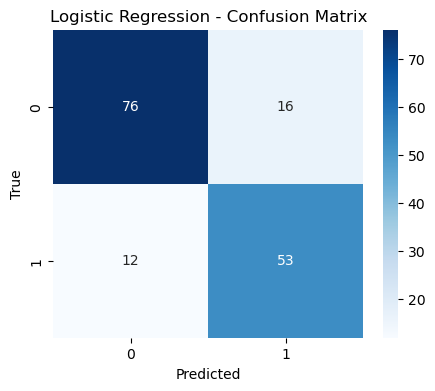


==== KNN (k=5) EVALUATION ====

Accuracy: 0.7643

Confusion Matrix:
 [[76 16]
 [21 44]]

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.83      0.80        92
           1       0.73      0.68      0.70        65

    accuracy                           0.76       157
   macro avg       0.76      0.75      0.75       157
weighted avg       0.76      0.76      0.76       157



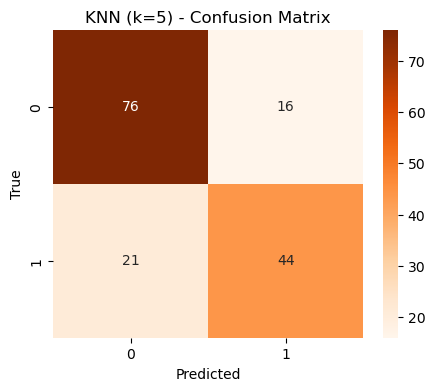


==== MODEL COMPARISON ====

Logistic Regression Accuracy : 0.8217
KNN Accuracy                : 0.7643

→ Final Choice: **Logistic Regression** performs better overall.


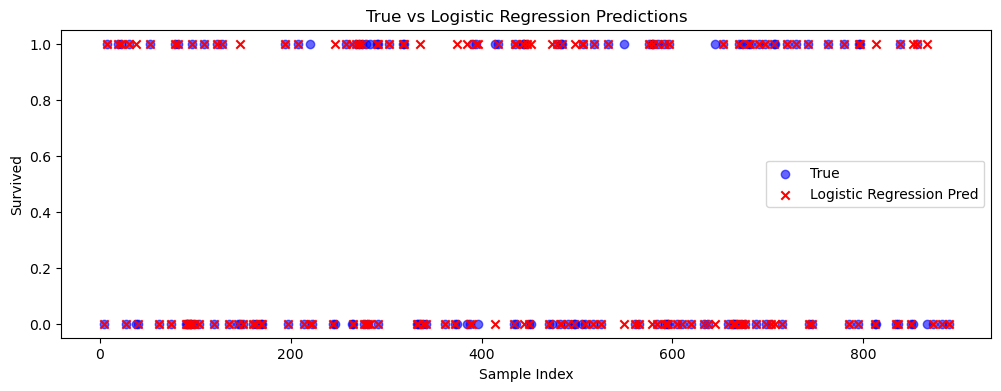

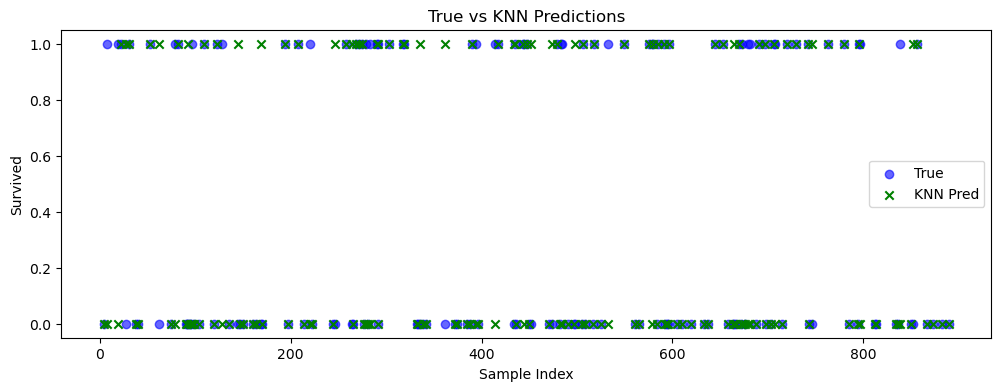

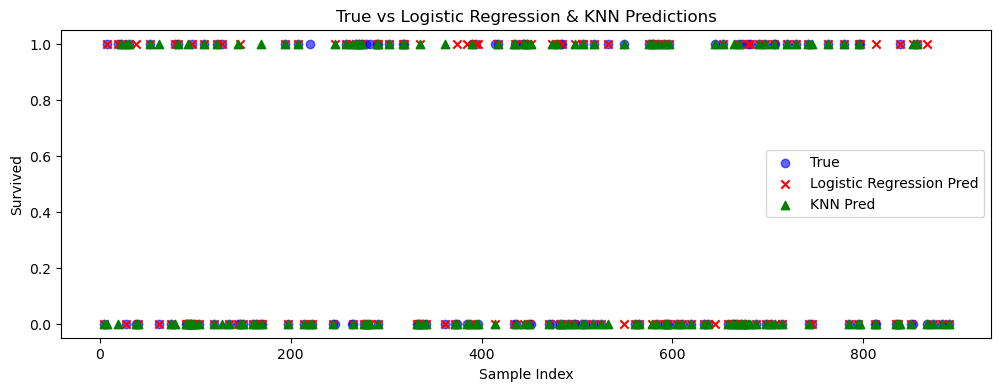

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.impute import SimpleImputer

# =====================================================
# 1) Load dataset
# =====================================================
df = sns.load_dataset("titanic")

# =====================================================
# 2) EDA (short)
# =====================================================
print(df.head())
print(df.info())
print(df.describe())

# =====================================================
# 3) Data Cleaning
# =====================================================

# Remove duplicates
df = df.drop_duplicates()

# Drop irrelevant columns
to_drop = ["deck", "embark_town", "alive", "who", "adult_male", "alone"]
df = df.drop(columns=to_drop)

# Handle missing values
# Age: median, Embarked: most frequent, Embarked: category
df["age"] = df["age"].fillna(df["age"].median())
df["embarked"] = df["embarked"].fillna(df["embarked"].mode()[0])
df["embarked"] = df["embarked"].astype(str)

# Fare: fill with median
df["fare"] = df["fare"].fillna(df["fare"].median())

# =====================================================
# 4) Feature Engineering
# =====================================================

# Family size: sibsp + parch + 1
df["family_size"] = df["sibsp"] + df["parch"] + 1

# IsAlone: boolean
df["is_alone"] = (df["family_size"] == 1).astype(int)

# Extract title from name
df["title"] = df["class"].astype(str)   # seaborn titanic doesn't have names
# (we simulate a simple categorical feature)

# =====================================================
# 5) Outlier Handling (Fare using IQR)
# =====================================================
Q1 = df["fare"].quantile(0.25)
Q3 = df["fare"].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5*IQR
upper = Q3 + 1.5*IQR

df["fare"] = np.where(df["fare"] > upper, upper,
                      np.where(df["fare"] < lower, lower, df["fare"]))

# =====================================================
# 6) Prepare input/output
# =====================================================
target = "survived"
X = df.drop(columns=[target])
y = df[target]

# Identify numeric / categorical features
numeric_features = ["age", "sibsp", "parch", "fare", "family_size"]
categorical_features = ["sex", "embarked", "class"]

# =====================================================
# 7) Preprocessing Pipelines
# =====================================================

numeric_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_pipeline, numeric_features),
    ("cat", categorical_pipeline, categorical_features)
])

# =====================================================
# 8) Train/Test Split
# =====================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# =====================================================
# 9) Modeling: Logistic Regression
# =====================================================
logreg_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("classifier", LogisticRegression(max_iter=500))
])

logreg_model.fit(X_train, y_train)
y_pred_lr = logreg_model.predict(X_test)

print("\n===== Logistic Regression =====")
print(classification_report(y_test, y_pred_lr))

# =====================================================
# 10) Modeling: K-Nearest Neighbors
# =====================================================
knn_model = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("classifier", KNeighborsClassifier(n_neighbors=5))
])

knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)

print("\n===== KNN (k=5) =====")
print(classification_report(y_test, y_pred_knn))


from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# =====================================================
# 1) Evaluate Logistic Regression
# =====================================================
print("\n==== LOGISTIC REGRESSION EVALUATION ====\n")

lr_acc = accuracy_score(y_test, y_pred_lr)
lr_cm = confusion_matrix(y_test, y_pred_lr)

print(f"Accuracy: {lr_acc:.4f}")
print("\nConfusion Matrix:\n", lr_cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))

# Plot confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(lr_cm, annot=True, fmt='d', cmap='Blues')
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# =====================================================
# 2) Evaluate KNN
# =====================================================
print("\n==== KNN (k=5) EVALUATION ====\n")

knn_acc = accuracy_score(y_test, y_pred_knn)
knn_cm = confusion_matrix(y_test, y_pred_knn)

print(f"Accuracy: {knn_acc:.4f}")
print("\nConfusion Matrix:\n", knn_cm)
print("\nClassification Report:\n", classification_report(y_test, y_pred_knn))

# Plot confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(knn_cm, annot=True, fmt='d', cmap='Oranges')
plt.title("KNN (k=5) - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# =====================================================
# 3) Compare the Models
# =====================================================
print("\n==== MODEL COMPARISON ====\n")
print(f"Logistic Regression Accuracy : {lr_acc:.4f}")
print(f"KNN Accuracy                : {knn_acc:.4f}")

if lr_acc > knn_acc:
    print("\n→ Final Choice: **Logistic Regression** performs better overall.")
elif knn_acc > lr_acc:
    print("\n→ Final Choice: **KNN** performs better overall.")
else:
    print("\n→ Both models have identical accuracy — use precision/recall of class 1 to decide.")


import matplotlib.pyplot as plt

# =====================================================
# Create a DataFrame for comparison
# =====================================================
comparison_df = X_test.copy()
comparison_df['True'] = y_test.values
comparison_df['LogReg_Pred'] = y_pred_lr
comparison_df['KNN_Pred'] = y_pred_knn

# =====================================================
# Plot differences for Logistic Regression
# =====================================================
plt.figure(figsize=(12,4))
plt.scatter(comparison_df.index, comparison_df['True'], color='blue', label='True', alpha=0.6)
plt.scatter(comparison_df.index, comparison_df['LogReg_Pred'], color='red', marker='x', label='Logistic Regression Pred')
plt.title("True vs Logistic Regression Predictions")
plt.xlabel("Sample Index")
plt.ylabel("Survived")
plt.legend()
plt.show()

# =====================================================
# Plot differences for KNN
# =====================================================
plt.figure(figsize=(12,4))
plt.scatter(comparison_df.index, comparison_df['True'], color='blue', label='True', alpha=0.6)
plt.scatter(comparison_df.index, comparison_df['KNN_Pred'], color='green', marker='x', label='KNN Pred')
plt.title("True vs KNN Predictions")
plt.xlabel("Sample Index")
plt.ylabel("Survived")
plt.legend()
plt.show()

# =====================================================
# Optional: Compare both predictions together
# =====================================================
plt.figure(figsize=(12,4))
plt.scatter(comparison_df.index, comparison_df['True'], color='blue', label='True', alpha=0.6)
plt.scatter(comparison_df.index, comparison_df['LogReg_Pred'], color='red', marker='x', label='Logistic Regression Pred')
plt.scatter(comparison_df.index, comparison_df['KNN_Pred'], color='green', marker='^', label='KNN Pred')
plt.title("True vs Logistic Regression & KNN Predictions")
plt.xlabel("Sample Index")
plt.ylabel("Survived")
plt.legend()
plt.show()
